## Planteamiento del ejercicio

Se propone comparar dos modelos para realizar una clasificación de coberturas usando la siguiente metodología.

1. Validar si la inclusión de la variable modelo digital de elevación incrementa la exactitud de la clasificación
2. Entrenar un modelo de bosques aleatorios (*Random Forest*) para clasificación de coberturas (optimizado)
2. Entrenar un modelo de red neuronal artificial *feedforwar* para clasificación coberturas (optimizado)
3. Comparar métricas de clasificación y revisión visual de resultados.
4. Tomar mejor resultado para como etiquetado para UNET
5. Entrenar UNET y validar resultados en otras áreas

Para la clasificación se definen las siguientes coberturas:

- 0: Sin dato, partes de la ortofoto que no tienen información
- 1: Edificaciones, incluye viviendas, edificios, bodegas
- 2: Vías, incluye vías principales y secundarias, no incluye caminos de finca ni placa huella
- 3: Vegetación alta, incluye árboles, arbustos, palmeras, guaduales
- 4: Vegetación baja, incluye pasto, cultivos de hortalizas
- 5: Suelo desnudo, incluye zonas sin vegetación, edificaciones o uso industrial o comercial
- 6: Cuerpo de agua natural, incluye ríos, lagos y lagunas
- 7: Cuerpo de agua artificial, incluye piscinas
- 8: Otro urbano, incluye caminos de fincas, placa huella, canchas de futbol, parques


## Importar librerías

In [1]:
# importar librerias
import os
from datetime import datetime

import geopandas as gpd
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from osgeo import gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model


2025-03-07 11:41:09.059204: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# ajustar estilos de graficas
sns.set(style='darkgrid', # color de fondo
        palette='colorblind' # colores de barras
        )

color_etiquetas = {
    'sin dato':'#000000',
    'edificaciones':'#fb0f0a',
    'vías':'#f60eeb',
    'vegetación alta':'#0f9a2c',
    'vegetación baja':'#9af836',
    'suelo desnudo':'#f6fd05',
    'cuerpo de agua natural':'#0125fd',
    'cuerpo de agua artificial':'#6cf3e5',
    'otro urbano':'#a4a0a8'
}


## Localización general

El área de estudio se encuentra entre los municipios de Copacabana y Girardota, en el departamento de Antioquia, Colombia. Tiene una extensión de 3,15 $km^2$. Sobre esta se realizó un vuelo fotogramétrico de dron, cuya información fue procesada en el software Pix4D para generar una ortofoto y un modelo digital de superficie

![localizacion_general](./img/localizacion_general_.png)

## Descripción general de los datos

### Ortofoto

La ortofoto base, fue tomada el 12 de julio de 2024, cubre una extensión de 3,15 $Km^2$. Las características técnicas de la ortofoto se presentan en la siguiente tabla

<center>

| Banda |            Descripción             |  Resolución radiométrica  |   Rango de valores    |  Resolución espacial [m]  |  Formato  |
|:-----:|:----------------------------------:|:-------------------------:|:---------------------:|:-------------------------:|:---------:|             
|   1   |             color rojo             |            8 bit          |        0 - 255        |            0.20           |  GeoTIFF  |
|   2   |             color verde            |            8 bit          |        0 - 255        |            0.20           |  GeoTIFF  |
|   3   |             color azul             |            8 bit          |        0 - 255        |            0.20           |  GeoTIFF  |
|   4   | modelo digital de superficie -dsm- |            32 bit         | 1330.6478 - 1633.6464 |            0.20           |  GeoTIFF  |

</center>

### Datos de entrenamiento

Los datos de entrenamiento corresponden con 9000 puntos distribuidos en la ortofoto, 1000 por cada clase, con los cuales se obtuvieron los valores de las bandas RGB y del modelo digital de superficie. La distribución de los puntos se realizó de forma tal que se cubriera la extensión de la imagen para tener información sobre la variación de los datos de cada categoría. En la siguiente imagen se presenta la distribución de los puntos.

![distribucion_puntos_muestra](./img/distribucion_puntos_muestra.png)

In [ ]:
# cargar puntos de entrenamiento
ruta_gpkg = "info_etiquetas.gpkg"
gdf_datos_entrenamiento = gpd.read_file(ruta_gpkg, layer="valores_etiquetas")
gdf_datos_entrenamiento.head()


,cod_n,etiqueta,valor_r,valor_g,valor_b,valor_dsm,geometry
0,3,vegetación alta,17.0,36.0,29.0,1434.024048,POINT (446417.663 704632.386)
1,3,vegetación alta,49.0,60.0,46.0,1476.967041,POINT (446198.521 704929.724)
2,4,vegetación baja,86.0,94.0,79.0,1443.200562,POINT (446135.505 704618.22)
3,3,vegetación alta,69.0,82.0,56.0,1481.812012,POINT (446101.595 705025.738)
4,3,vegetación alta,76.0,92.0,70.0,1449.640625,POINT (446197.307 704634.814)


In [4]:
# obtener valores unicos de cod_n y etiqueta
cod_n_unique = gdf_datos_entrenamiento["cod_n"].unique()
etiquetas_unique = gdf_datos_entrenamiento["etiqueta"].unique()

# crear diccionario para mapear cod_n a etiqueta
definicion_clases = dict(zip(cod_n_unique, etiquetas_unique))
definicion_clases


{3: 'vegetación alta',
 4: 'vegetación baja',
 2: 'vías',
 8: 'otro urbano',
 7: 'cuerpo de agua artificial',
 6: 'cuerpo de agua natural',
 1: 'edificaciones',
 5: 'suelo desnudo',
 0: 'sin dato'}

In [5]:
# lista de etiquetas en orden de llave de diccionario
n_etiquetas = [
    "0 - sin dato",
    "1 - edificaciones",
    "2 - vías",
    "3 - vegetación alta",
    "4 - vegetación baja",
    "5 - suelo desnudo",
    "6 - cuerpo de agua natural",
    "7 - cuerpo de agua artificial",
    "8 - otro urbano",
]


### Análisis exploratorio de datos

In [6]:
# tipo de datos
gdf_datos_entrenamiento.dtypes

cod_n           int32
etiqueta       object
valor_r       float64
valor_g       float64
valor_b       float64
valor_dsm     float64
geometry     geometry
dtype: object

In [7]:
# cuantas variable de cada tipo
gdf_datos_entrenamiento.dtypes.value_counts()

float64     4
int32       1
object      1
geometry    1
Name: count, dtype: int64

In [8]:
# dimensiones de la capa de entrenamiento
gdf_datos_entrenamiento.shape

(9000, 7)

In [9]:
# validar si existen valores nulos
gdf_datos_entrenamiento.isnull().sum()

cod_n        0
etiqueta     0
valor_r      0
valor_g      0
valor_b      0
valor_dsm    0
geometry     0
dtype: int64

In [10]:
# estadisticos de las variables RGB y DSM
gdf_datos_entrenamiento[['valor_r', 'valor_g', 'valor_b', 'valor_dsm']].describe()

,valor_r,valor_g,valor_b,valor_dsm
count,9000.000000,9000.000000,9000.000000,9000.000000
mean,115.878000,120.693889,110.657222,1457.534010
std,62.474358,62.153552,66.105180,42.161317
min,0.000000,0.000000,0.000000,1334.896240
25%,75.000000,89.000000,67.000000,1428.057098
50%,120.000000,124.000000,109.000000,1454.604858
75%,161.000000,156.000000,151.000000,1487.447357
max,255.000000,255.000000,255.000000,1631.198242


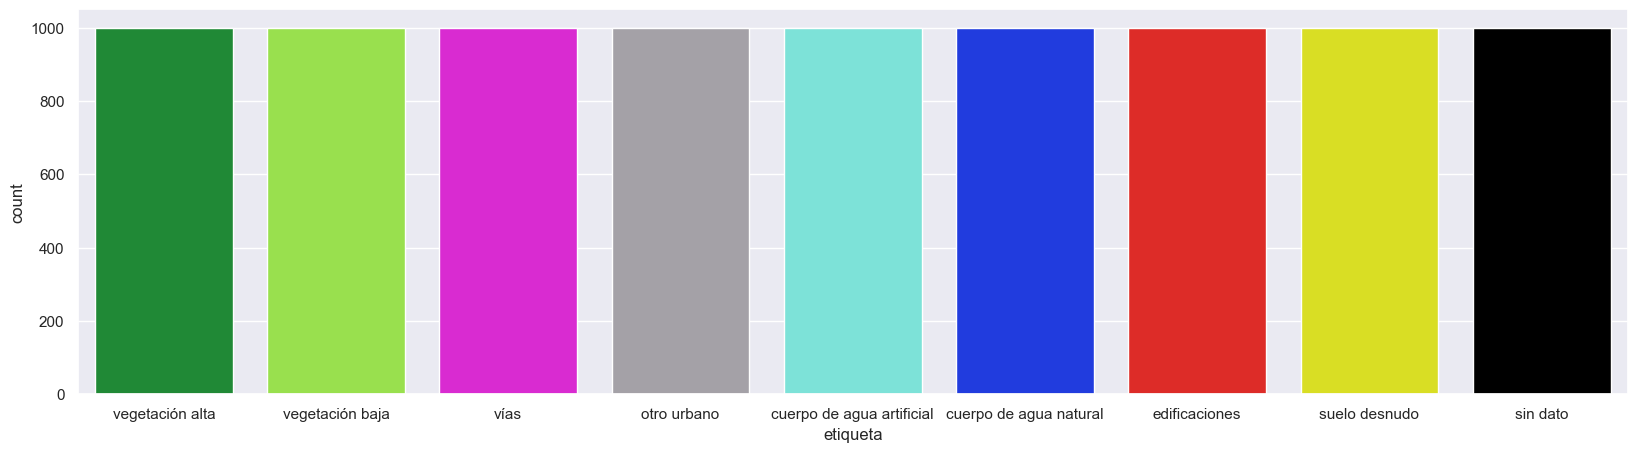

In [11]:
# validar proporcion de datos
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.countplot(
    data=gdf_datos_entrenamiento,
    x='etiqueta',
    hue='etiqueta',
    legend=False,
    palette=color_etiquetas,
    ax=axes
);


In [12]:
# correlacion entre variables RGB y DSM
gdf_datos_entrenamiento[['valor_r', 'valor_g', 'valor_b', 'valor_dsm']].corr()

,valor_r,valor_g,valor_b,valor_dsm
valor_r,1.000000,0.934373,0.859858,-0.259692
valor_g,0.934373,1.000000,0.947713,-0.219263
valor_b,0.859858,0.947713,1.000000,-0.234631
valor_dsm,-0.259692,-0.219263,-0.234631,1.000000


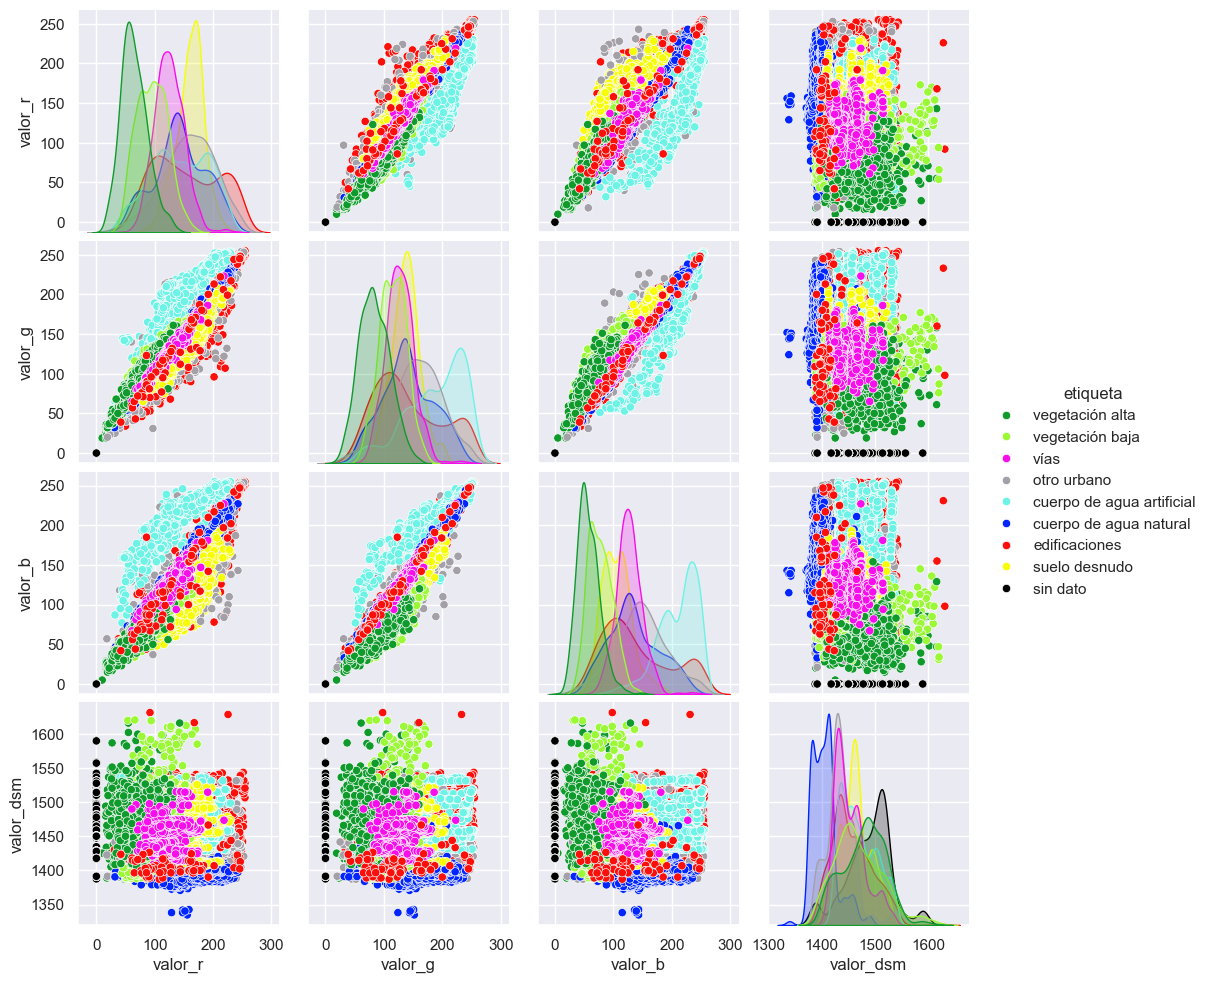

In [13]:
sns.pairplot(
    data=gdf_datos_entrenamiento[["valor_r", "valor_g", "valor_b", "valor_dsm", "etiqueta"]],
    hue='etiqueta',
    palette=color_etiquetas
);

Se puede apreciar en la última gráfica que las bandas RGB tienen alta correlación positiva y que al agregar el DSM se establecen espacios con mayor facilidad para diferenciar las coberturas definidas, por lo que incluir esta variable puede resultar en un incremento de la exactitud global.

### Preparar datos para clasificaciones

In [14]:
# preparar datos sin altura
X_muestras_sin_altura = gdf_datos_entrenamiento[
    ["valor_r", "valor_g", "valor_b"]
].to_numpy()

# preparar datos con altura
X_muestras_altura = gdf_datos_entrenamiento[
    ["valor_r", "valor_g", "valor_b", "valor_dsm"]
].to_numpy()

# preparar etiquetas
y_etiquetas = gdf_datos_entrenamiento["cod_n"].to_numpy()


In [15]:
# modelo para escalar los datos sin altura
escalador_sin_altura = StandardScaler()

# modelo para escalar los datos con altura
escalador_altura = StandardScaler()

# escalar las variables sin altura
X_muestras_sin_altura_escaladas = escalador_sin_altura.fit_transform(
    X_muestras_sin_altura
)

# escalar las variables con altura
X_muestras_altura_escaladas = escalador_altura.fit_transform(X_muestras_altura)


In [16]:
# dividir datos en entrenamiento y prueba sin altura 80% entrenamiento 20% prueba
(
    X_entrenamiento_sin_altura,
    X_prueba_sin_altura,
    y_entrenamiento_sin_altura,
    y_prueba_sin_altura,
) = train_test_split(
    X_muestras_sin_altura_escaladas, y_etiquetas, test_size=0.2, random_state=42
)

# dividir datos en entrenamiento y prueba con altura 80% entrenamiento 20% prueba
X_entrenamiento_altura, X_prueba_altura, y_entrenamiento_altura, y_prueba_altura = (
    train_test_split(
        X_muestras_altura_escaladas, y_etiquetas, test_size=0.2, random_state=42
    )
)


## Modelo bosques aleatorios (*Random Forest*)

En este apartado se evalúa si la inclusión de la variable `modelo digital de superficie -dsm-` incrementa la exactitud *accuray* del modelo.
También se revisan métricas como precisión *precision* exactitud de clase *recall* e índice f1-score.

Posterior a la evaluación de la inclusión de la variable dsm, se realiza la optimización de los hiperparámetros `n_estimator` y `max_features`, dos los principales hiperparámetros en el modelo de bosques aleatorios, con la finalidad de obtener el mejor modelo posible.

### Evaluar inclusión de la variable modelo digital de superficie (dsm)

Para la evaluación de la inclusión de la variable `dsm`, se definen dos modelos básicos de bosques aleatorios, con 100 árboles (`n_estimators=100`) y `random state=42`, los demás parámetros se dejan por defecto de acuerdo al uso corriente de la librería sklearn.

Los modelos son entrenados y validados, con los datos preparados con anterioridad y se genera un reporte de clasificación para comparar sus resultados.

In [17]:
# entrenar modelo Random Forest sin altura
clf_sin_altura = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sin_altura.fit(X_entrenamiento_sin_altura, y_entrenamiento_sin_altura)

# evaluar modelo
y_pred_sin_altura = clf_sin_altura.predict(X_prueba_sin_altura)

# reporte de clasificación
print(
    classification_report(
        y_prueba_sin_altura, y_pred_sin_altura, target_names=n_etiquetas
    )
)


                               precision    recall  f1-score   support

                 0 - sin dato       1.00      1.00      1.00       202
            1 - edificaciones       0.63      0.60      0.61       184
                     2 - vías       0.68      0.75      0.71       194
          3 - vegetación alta       0.74      0.69      0.71       210
          4 - vegetación baja       0.71      0.72      0.71       209
            5 - suelo desnudo       0.85      0.90      0.87       211
   6 - cuerpo de agua natural       0.52      0.56      0.54       194
7 - cuerpo de agua artificial       0.97      1.00      0.98       210
              8 - otro urbano       0.41      0.34      0.37       186

                     accuracy                           0.73      1800
                    macro avg       0.72      0.73      0.72      1800
                 weighted avg       0.73      0.73      0.73      1800



In [18]:
# entrenar modelo Random Forest con altura
clf_altura = RandomForestClassifier(n_estimators=100, random_state=42)
clf_altura.fit(X_entrenamiento_altura, y_entrenamiento_altura)

# Evaluar modelo
y_pred_altura = clf_altura.predict(X_prueba_altura)

# reporte de clasificación
print(classification_report(y_prueba_altura, y_pred_altura, target_names=n_etiquetas))


                               precision    recall  f1-score   support

                 0 - sin dato       1.00      1.00      1.00       202
            1 - edificaciones       0.71      0.68      0.70       184
                     2 - vías       0.77      0.88      0.82       194
          3 - vegetación alta       0.78      0.77      0.78       210
          4 - vegetación baja       0.78      0.75      0.76       209
            5 - suelo desnudo       0.92      0.93      0.93       211
   6 - cuerpo de agua natural       0.83      0.88      0.85       194
7 - cuerpo de agua artificial       0.99      1.00      0.99       210
              8 - otro urbano       0.66      0.56      0.61       186

                     accuracy                           0.83      1800
                    macro avg       0.83      0.83      0.83      1800
                 weighted avg       0.83      0.83      0.83      1800



Como se aprecia en los reportes, la inclusión del `dsm` incrementa un 10% la exactitud *accuracy* de la clasificación, las mejoras a nivel de clase se ven reflejadas en todas las coberturas con excepción de *sin dato*. Los incrementos en precisión se dan entre 1% y 31%, mientras que en *recall* los incrementos son entre 2% y el 32%. Estos incrementos se ven reflejados en el *f1-score* que presenta valores por encima del 0,61 lo que indica una relación precisión/recall más balanceada.

### Optimizar hiperparámetros para modelo de bosque aleatorios

Con base en los resultados previos, se realiza la optimización de parámetros del modelo de bosques aleatorios con la inclusión de la variable `dsm`. Como se mencionó con anterioridad, se buscará un mejor modelo variando los parámetros `n_estimators` y `max_features`, el ejercicio se realiza mediante validación cruzada con cinco (5), particiones. Los datos se mezclan (barajan) antes de realizar las particiones.

In [19]:
# alistar parametros para validacion cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# parametros de arboles aleatorios a probar
param_grid_rf = {
    "n_estimators": np.arange(100, 200, 10),
    "max_features": np.arange(1, 5, 1),
}

# crear modelo base de random forest
modelo_rf_base = RandomForestClassifier(random_state=42)

# realizar la busqueda de mejores hiperparametros
rf_busqueda = GridSearchCV(
    modelo_rf_base, param_grid_rf, cv=kfold, n_jobs=-1
)

# ajustar el modelo con los datos transformados
rf_busqueda.fit(X_entrenamiento_altura, y_entrenamiento_altura)


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_features': array([1, 2, 3, 4]),
                         'n_estimators': array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190])})

In [20]:
# optenemos los resultados de validacion cruzada
cv_resultados = pd.DataFrame(rf_busqueda.cv_results_)
cv_resultados[['mean_fit_time', 'param_max_features', 'param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')


,mean_fit_time,param_max_features,param_n_estimators,mean_test_score,rank_test_score
18,3.301754,2,180,0.825694,1
19,3.555844,2,190,0.824722,2
16,2.952870,2,160,0.824722,2
17,3.120122,2,170,0.824306,4
15,2.760707,2,150,0.823889,5
10,1.815837,2,100,0.823611,6
13,2.330754,2,130,0.823333,7
14,2.523945,2,140,0.823333,8
12,2.135740,2,120,0.823056,9
11,1.982528,2,110,0.822639,10


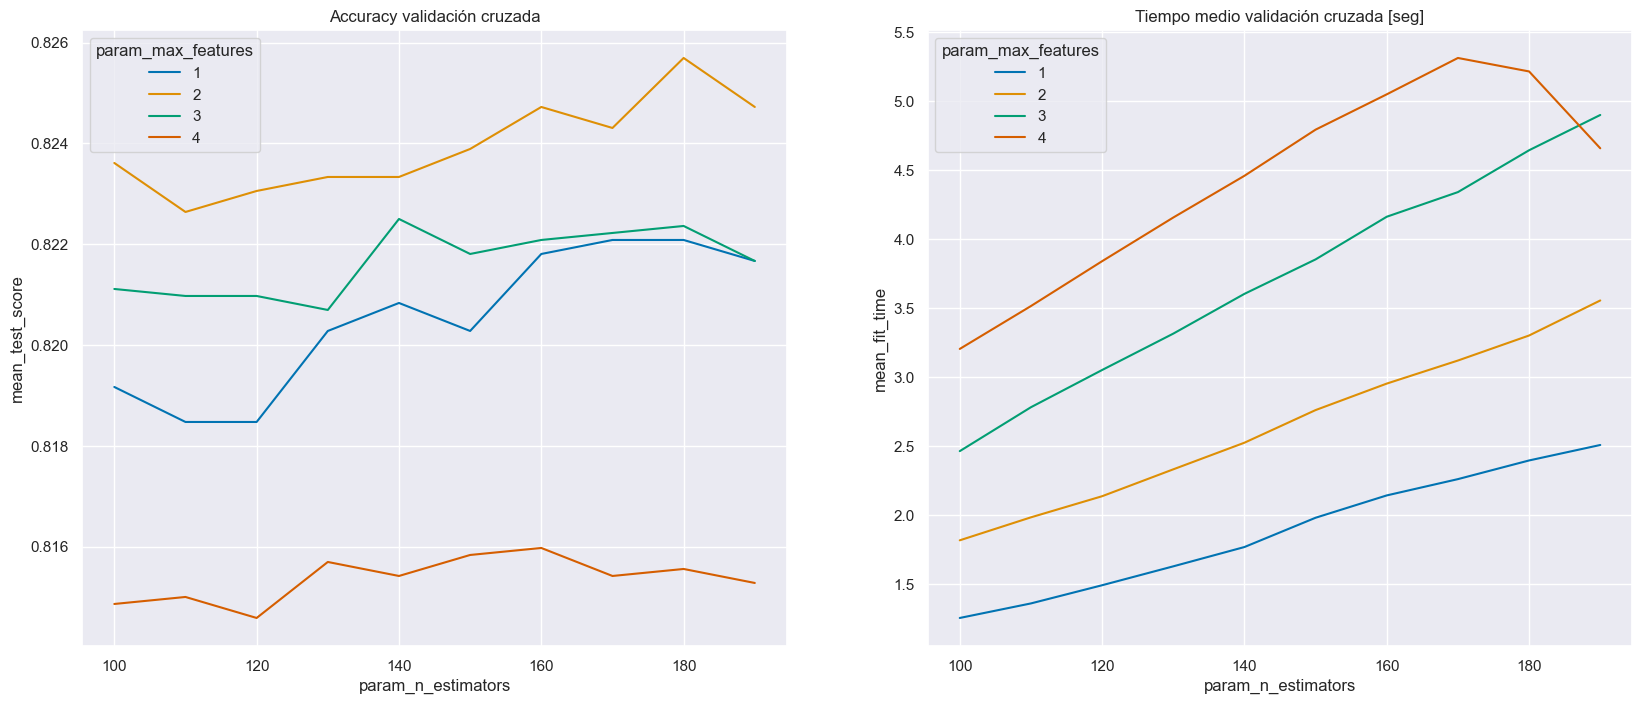

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(
    data=cv_resultados,
    x="param_n_estimators",
    y="mean_test_score",
    hue="param_max_features",
    palette="colorblind",
    ax=ax[0],
)
ax[0].set_title("Accuracy validación cruzada")

sns.lineplot(
    data=cv_resultados,
    x="param_n_estimators",
    y="mean_fit_time",
    hue="param_max_features",
    palette="colorblind",
    ax=ax[1],
)
ax[1].set_title("Tiempo medio validación cruzada [seg]")
plt.show();


In [22]:
# comibinacion de mejores parametros
print(rf_busqueda.best_params_)

{'max_features': 2, 'n_estimators': 180}


In [23]:
# evaluar el modelo
y_pred_altura_rf = rf_busqueda.best_estimator_.predict(X_prueba_altura)
print(classification_report(y_prueba_altura, y_pred_altura_rf, target_names=n_etiquetas))


                               precision    recall  f1-score   support

                 0 - sin dato       1.00      1.00      1.00       202
            1 - edificaciones       0.70      0.70      0.70       184
                     2 - vías       0.77      0.88      0.82       194
          3 - vegetación alta       0.77      0.79      0.78       210
          4 - vegetación baja       0.78      0.73      0.76       209
            5 - suelo desnudo       0.93      0.92      0.93       211
   6 - cuerpo de agua natural       0.84      0.90      0.87       194
7 - cuerpo de agua artificial       0.99      1.00      0.99       210
              8 - otro urbano       0.67      0.55      0.61       186

                     accuracy                           0.83      1800
                    macro avg       0.83      0.83      0.83      1800
                 weighted avg       0.83      0.83      0.83      1800



Como resultado del ejercicio de optimización de hiperparámetros se obtuvo que los mejores valores de `n_estimators` y `max_features` son 180 y 2 respectivamente.

El *accuracy* no tiene variación respecto al modelo de 100 árboles y parámetros por defecto, sin embargo se ve una mejora ligera a nivel categoría de cobertura en *cuerpo de agua natural*.

Teniendo en cuenta que la diferencia de tiempo de ajuste del modelo no es significativa, pues es del orden segundos, se dejará el modelo hallado mediante validación cruzada para comparar con la red neuronal feedforward.

## Entrenamiento de una red neuronal *feedforward*

Se crean dos redes feedforward con tres capas de 100 neuronas cada una y una capa de salida con 9 clases, que corresponden con las coberturas definidas.

Sobre estas redes se evalua el optimizador a utilizar, se comparan `Gradiente Descendente`, `Gradiente Descendente - Nesterov` y `Adam`. Se elige el optimizador que mejor desempeño tenga y se procede con la optimización de hiperparámetros para construir una mejor red.


### Compilación de modelo con Gradiente Descendente -SGD-

In [29]:
# se define numero de neuronas por capa oculta
n_neuronas = [100, 100, 100]
n_clases = len(definicion_clases.items())

# se crea lista para agregar capas
capas = []

# se agrega la capa de entrada
capas.append(keras.layers.InputLayer(shape=(X_entrenamiento_altura.shape[1],)))

# se agrengan las capas ocultas
for capa in n_neuronas:
    capas.append(keras.layers.Dense(capa, activation="relu"))

# se agrega la capa de salida
capas.append(keras.layers.Dense(n_clases, activation="softmax"))

# se crea el modelos sgd, nesterov y adam
modelo_sgd = keras.Sequential(capas)

# revisamos la arquitectura del modelo
modelo_sgd.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,609 (84.41 KB)

 Trainable params: 21,609 (84.41 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# parametros de optimizador sgd
optimizador_sgd = keras.optimizers.SGD(learning_rate=1e-3)

# se compila el modelo
modelo_sgd.compile(
    optimizer=optimizador_sgd,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# configuracion de parada temprana
parada_temprana = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)


In [31]:
# se toma tiempo inicial
ti_sgd_base = datetime.now()

# entrenamos el modelo con 100 epocas
historial_sgd_base = modelo_sgd.fit(
    X_entrenamiento_altura,
    y_entrenamiento_altura,
    epochs=100,
    validation_data=(X_prueba_altura, y_prueba_altura),
    callbacks=[parada_temprana],
)

# se toma tiempo final
tf_sgd_base = datetime.now()

# se calcula la duracion
duracion_sgd_base = tf_sgd_base - ti_sgd_base


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1558 - loss: 2.1822 - val_accuracy: 0.1767 - val_loss: 2.1523
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2181 - loss: 2.1447 - val_accuracy: 0.2667 - val_loss: 2.1146
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2868 - loss: 2.1048 - val_accuracy: 0.2911 - val_loss: 2.0796
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2975 - loss: 2.0731 - val_accuracy: 0.2994 - val_loss: 2.0452
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3096 - loss: 2.0382 - val_accuracy: 0.3161 - val_loss: 2.0104
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3237 - loss: 1.9976 - val_accuracy: 0.3339 - val_loss: 1.9754
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3329 - loss: 1.9792 - val_accuracy: 0.3428 - val_loss: 1.9412
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3489 - loss: 1.9345 - val_accu

In [32]:
# evaluamos modelo
evaluacion_sgd = modelo_sgd.evaluate(X_prueba_altura, y_prueba_altura)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7248 - loss: 0.8035


In [33]:
# prediccion de clasificacion para crear matriz de confusion
y_pred_sgd = modelo_sgd.predict(X_prueba_altura)
y_pred_sgd_clases = [np.argmax(elemento) for elemento in y_pred_sgd]

# reporte de clasificacion
print(classification_report(y_prueba_altura, y_pred_sgd_clases, target_names=n_etiquetas))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                               precision    recall  f1-score   support

                 0 - sin dato       0.97      1.00      0.99       202
            1 - edificaciones       0.41      0.23      0.29       184
                     2 - vías       0.64      0.77      0.70       194
          3 - vegetación alta       0.65      0.72      0.68       210
          4 - vegetación baja       0.61      0.61      0.61       209
            5 - suelo desnudo       0.70      0.86      0.77       211
   6 - cuerpo de agua natural       0.65      0.77      0.71       194
7 - cuerpo de agua artificial       0.97      1.00      0.98       210
              8 - otro urbano       0.52      0.31      0.39       186

                     accuracy                           0.71      1800
                    macro avg       0.68      0.70      0.68      1800
                 weighted avg       0.69      0.71      0.69      1800



### Compilación de modelo con SGD - Nesterov

In [34]:
# se define numero de neuronas por capa oculta
n_neuronas = [100, 100, 100]
n_clases = len(definicion_clases.items())

# se crea lista para agregar capas
capas = []

# se agrega la capa de entrada
capas.append(keras.layers.InputLayer(shape=(X_entrenamiento_altura.shape[1],)))

# se agrengan las capas ocultas
for capa in n_neuronas:
    capas.append(keras.layers.Dense(capa, activation="relu"))

# se agrega la capa de salida
capas.append(keras.layers.Dense(n_clases, activation="softmax"))

# se crea el modelos sgd, nesterov y adam
modelo_nesterov = keras.Sequential(capas)

# revisamos la arquitectura del modelo
modelo_nesterov.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,609 (84.41 KB)

 Trainable params: 21,609 (84.41 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# parametros de optimizador sgd nesterov
optimizador_sgd_nesterov = keras.optimizers.SGD(
    learning_rate=1e-3, momentum=0.9, nesterov=True
)

# compilacion de modelo con optimizador Nesterov
modelo_nesterov.compile(
    optimizer=optimizador_sgd_nesterov,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# configuracion de parada temprana
parada_temprana = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)


In [36]:
# se toma tiempo inicial
ti_sgd_nesterov = datetime.now()

# entrenamos el modelo
historial_sgd_nesterov = modelo_nesterov.fit(
    X_entrenamiento_altura,
    y_entrenamiento_altura,
    epochs=100,
    validation_data=(X_prueba_altura, y_prueba_altura),
    callbacks=[parada_temprana],
)

# se toma tiempo final
tf_sgd_nesterov = datetime.now()

# se calcula la duracion
duracion_sgd_nesterov = tf_sgd_nesterov - ti_sgd_nesterov


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1830 - loss: 2.1375 - val_accuracy: 0.3294 - val_loss: 1.8798
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3420 - loss: 1.8212 - val_accuracy: 0.4022 - val_loss: 1.6197
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4273 - loss: 1.5807 - val_accuracy: 0.4950 - val_loss: 1.4381
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5068 - loss: 1.4097 - val_accuracy: 0.5922 - val_loss: 1.2878
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5934 - loss: 1.2591 - val_accuracy: 0.6339 - val_loss: 1.1451
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6338 - loss: 1.1234 - val_accuracy: 0.6733 - val_loss: 1.0194
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6684 - loss: 0.9970 - val_accuracy: 0.6889 - val_loss: 0.9214
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6850 - loss: 0.9306 - val_accu

In [37]:
# evaluamos modelo
evaluacion_sgd_nesterov = modelo_nesterov.evaluate(X_prueba_altura, y_prueba_altura)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.5476


In [38]:
# prediccion de clasificacion para crear matriz de confusion
y_pred_nesterov = modelo_nesterov.predict(X_prueba_altura)
y_pred_nesterov_clases = [np.argmax(elemento) for elemento in y_pred_nesterov]

# reporte de clasificacion
print(classification_report(y_prueba_altura, y_pred_nesterov_clases, target_names=n_etiquetas))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                               precision    recall  f1-score   support

                 0 - sin dato       0.99      1.00      0.99       202
            1 - edificaciones       0.69      0.64      0.67       184
                     2 - vías       0.69      0.89      0.78       194
          3 - vegetación alta       0.75      0.68      0.71       210
          4 - vegetación baja       0.69      0.75      0.72       209
            5 - suelo desnudo       0.86      0.93      0.89       211
   6 - cuerpo de agua natural       0.76      0.80      0.78       194
7 - cuerpo de agua artificial       0.98      1.00      0.99       210
              8 - otro urbano       0.62      0.38      0.47       186

                     accuracy                           0.79      1800
                    macro avg       0.78      0.79      0.78      1800
                 weighted avg       0.79      0.79      0.78      1800



### Compilación e modelo con Adam

In [39]:
# se define numero de neuronas por capa oculta
n_neuronas = [100, 100, 100]
n_clases = len(definicion_clases.items())

# se crea lista para agregar capas
capas = []

# se agrega la capa de entrada
capas.append(keras.layers.InputLayer(shape=(X_entrenamiento_altura.shape[1],)))

# se agrengan las capas ocultas
for capa in n_neuronas:
    capas.append(keras.layers.Dense(capa, activation="relu"))

# se agrega la capa de salida
capas.append(keras.layers.Dense(n_clases, activation="softmax"))

# se crea el modelos sgd, nesterov y adam
modelo_adam = keras.Sequential(capas)

# revisamos la arquitectura del modelo
modelo_adam.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,609 (84.41 KB)

 Trainable params: 21,609 (84.41 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# parametros de optimizador adam
optimizador_adam = keras.optimizers.Adam(learning_rate=1e-3)

# compilacion de modelo con optimizador adam
modelo_adam.compile(
    optimizer=optimizador_adam,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# configuracion de parada temprana
parada_temprana = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)


In [41]:
# se toma tiempo inicial
ti_adam = datetime.now()

# entrenamos el modelo
historial_adam = modelo_adam.fit(
    X_entrenamiento_altura,
    y_entrenamiento_altura,
    epochs=100,
    validation_data=(X_prueba_altura, y_prueba_altura),
    callbacks=[parada_temprana],
)

# se toma tiempo final
tf_adam = datetime.now()

# se calcula la duracion
duracion_adam = tf_adam - ti_adam


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4401 - loss: 1.5135 - val_accuracy: 0.7644 - val_loss: 0.6761
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7579 - loss: 0.6728 - val_accuracy: 0.7833 - val_loss: 0.5837
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7809 - loss: 0.5869 - val_accuracy: 0.7967 - val_loss: 0.5350
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7883 - loss: 0.5544 - val_accuracy: 0.8050 - val_loss: 0.5055
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7927 - loss: 0.5226 - val_accuracy: 0.8011 - val_loss: 0.5220
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8045 - loss: 0.5088 - val_accuracy: 0.8061 - val_loss: 0.4941
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8026 - loss: 0.4974 - val_accuracy: 0.8028 - val_loss: 0.4998
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8177 - loss: 0.4822 - val_accu

In [42]:
# evaluamos modelo
evaluacion_adam = modelo_adam.evaluate(X_prueba_altura, y_prueba_altura)


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8282 - loss: 0.4272


In [43]:
# prediccion de clasificacion para crear matriz de confusion
y_pred_adam = modelo_adam.predict(X_prueba_altura)
y_pred_adam_clases = [np.argmax(elemento) for elemento in y_pred_adam]

# reporte de clasificacion
print(classification_report(y_prueba_altura, y_pred_adam_clases, target_names=n_etiquetas))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                               precision    recall  f1-score   support

                 0 - sin dato       0.99      1.00      1.00       202
            1 - edificaciones       0.76      0.62      0.68       184
                     2 - vías       0.74      0.93      0.82       194
          3 - vegetación alta       0.77      0.76      0.77       210
          4 - vegetación baja       0.76      0.73      0.74       209
            5 - suelo desnudo       0.92      0.92      0.92       211
   6 - cuerpo de agua natural       0.79      0.91      0.85       194
7 - cuerpo de agua artificial       0.99      1.00      0.99       210
              8 - otro urbano       0.58      0.45      0.51       186

                     accuracy                           0.82      1800
                    macro avg       0.81      0.81      0.81      1800
                 weighted avg       0.81      0.82      0.81      1800



### Comparación de resultados

/var/folders/0t/_s3xwwj96f9bq508dbkp4wpc0000gn/T/ipykernel_16484/631135786.py:93: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


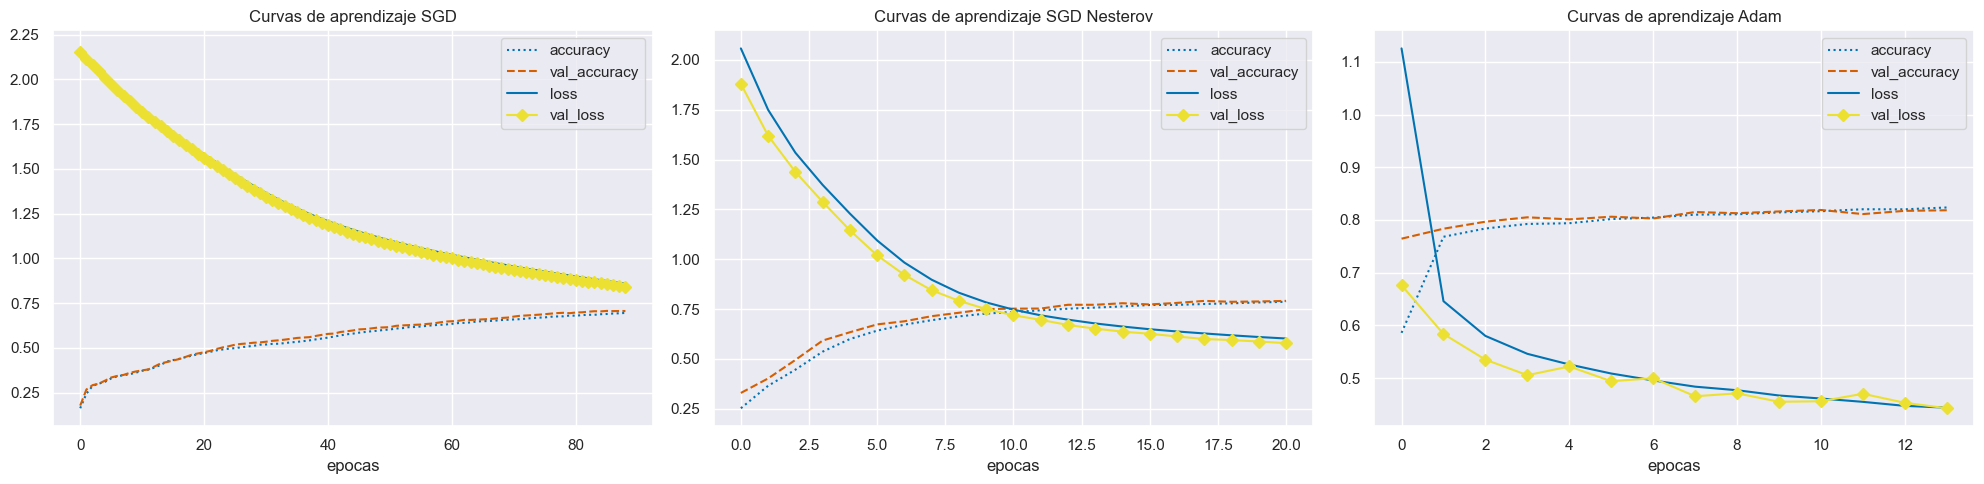

In [44]:
# crear dataframes de histiales de entrenamiento
df_historial_sgd = pd.DataFrame(historial_sgd_base.history)
df_historial_sgd_nesterov = pd.DataFrame(historial_sgd_nesterov.history)
df_historial_adam = pd.DataFrame(historial_adam.history)

# graficar curvas de aprendizaje
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# se grafica en el axes[0]
axes[0].plot(
    np.arange(0, df_historial_sgd.shape[0]),
    df_historial_sgd["accuracy"],
    "b:",
    label="accuracy",
)
axes[0].plot(
    np.arange(0, df_historial_sgd.shape[0]),
    df_historial_sgd["val_accuracy"],
    "r--",
    label="val_accuracy",
)
axes[0].plot(
    np.arange(0, df_historial_sgd.shape[0]), df_historial_sgd["loss"], label="loss"
)
axes[0].plot(
    np.arange(0, df_historial_sgd.shape[0]),
    df_historial_sgd["val_loss"],
    "yD-",
    label="val_loss",
)
axes[0].set_title("Curvas de aprendizaje SGD")  # se agrega titulo a grafica
axes[0].set_xlabel("epocas")  # se agrega titulo de eje x
axes[0].legend()  # para mostrar nombre de lineas o leyenda de la grafica

# grafica en el axes[1]
axes[1].plot(
    np.arange(0, df_historial_sgd_nesterov.shape[0]),
    df_historial_sgd_nesterov["accuracy"],
    "b:",
    label="accuracy",
)
axes[1].plot(
    np.arange(0, df_historial_sgd_nesterov.shape[0]),
    df_historial_sgd_nesterov["val_accuracy"],
    "r--",
    label="val_accuracy",
)
axes[1].plot(
    np.arange(0, df_historial_sgd_nesterov.shape[0]),
    df_historial_sgd_nesterov["loss"],
    label="loss",
)
axes[1].plot(
    np.arange(0, df_historial_sgd_nesterov.shape[0]),
    df_historial_sgd_nesterov["val_loss"],
    "yD-",
    label="val_loss",
)
axes[1].set_title("Curvas de aprendizaje SGD Nesterov")  # se agrega titulo a grafica
axes[1].set_xlabel("epocas")  # se agrega titulo de eje x
axes[1].legend()  # para mostrar nombre de lineas o leyenda de la grafica

# grafica en el axes[2]
axes[2].plot(
    np.arange(df_historial_adam.shape[0]),
    df_historial_adam["accuracy"],
    "b:",
    label="accuracy",
)
axes[2].plot(
    np.arange(df_historial_adam.shape[0]),
    df_historial_adam["val_accuracy"],
    "r--",
    label="val_accuracy",
)
axes[2].plot(
    np.arange(df_historial_adam.shape[0]), df_historial_adam["loss"], label="loss"
)
axes[2].plot(
    np.arange(df_historial_adam.shape[0]),
    df_historial_adam["val_loss"],
    "yD-",
    label="val_loss",
)
axes[2].set_title("Curvas de aprendizaje Adam")  # se agrega titulo a grafica
axes[2].set_xlabel("epocas")  # se agrega titulo de eje x
axes[2].legend()  # para mostrar nombre de lineas o leyenda de la grafica

# se ajusta la distancia entre figuras
fig.tight_layout()

# se muestra la figura
fig.show();

/var/folders/0t/_s3xwwj96f9bq508dbkp4wpc0000gn/T/ipykernel_16484/1086940502.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


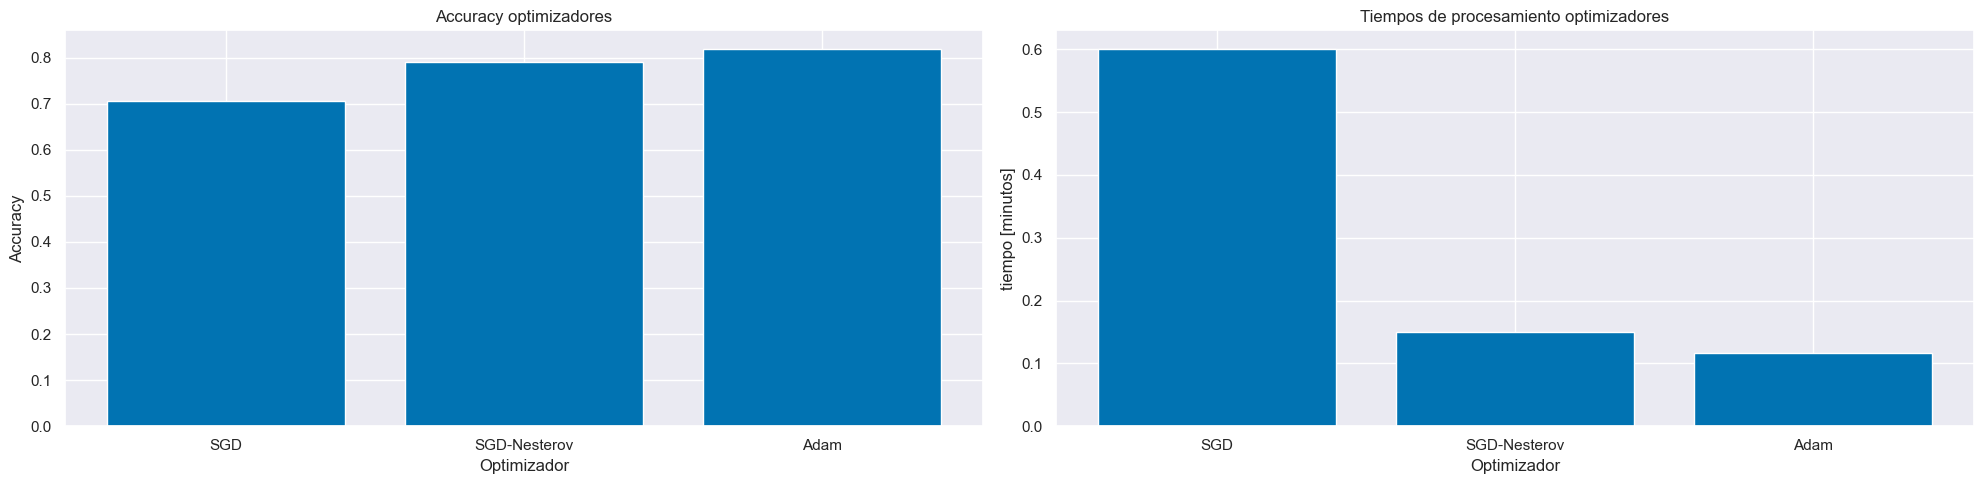

In [45]:
# graficar accuracy general y tiempo de procesamiento
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# se grafica en el axes[0]
axes[0].bar(
    ["SGD", "SGD-Nesterov", "Adam"],
    [evaluacion_sgd[1], evaluacion_sgd_nesterov[1], evaluacion_adam[1]],
)
axes[0].set_title("Accuracy optimizadores")  # se agrega titulo a grafica
axes[0].set_xlabel("Optimizador")  # se agrega titulo de eje x
axes[0].set_ylabel("Accuracy")  # se agrega titulo de eje x

# grafica en el axes[1]
axes[1].bar(
    ["SGD", "SGD-Nesterov", "Adam"],
    [duracion_sgd_base.seconds/60, duracion_sgd_nesterov.seconds/60, duracion_adam.seconds/60],
)
axes[1].set_title("Tiempos de procesamiento optimizadores")  # se agrega titulo a grafica
axes[1].set_xlabel("Optimizador")  # se agrega titulo de eje x
axes[1].set_ylabel("tiempo [minutos]")  # se agrega titulo de eje x

# se ajusta la distancia entre figuras
fig.tight_layout()

# se muestra la figura
fig.show();

Con base en los resultados obtenidos, el mejor optimizador para modelo de red *feedforward* es Adam, pues tiene mayor *accuracy* y tiempo de procesamiento menor. A continuación se realiza optimización de parámetros para la red con el optimizador Adam.

### Optimizar hiperparámetros para red *feedforward*

Se crea una función para construir los modelos de red que se probarán. Los parámetros a optimizar son:
- cantidad de capas: entre 3 y 5
- cantidad de neuronas por capa: entre 100 y 300
- funciones de activación en capas ocultas: relu, sigmoid y tanh
- tasas de aprendizaje para el optimizador: 1e-2, 1e-3, 1e-4


In [46]:
# definicion del modelo
def constructor_de_modelos(hp):
    # se declara variable global
    global X_entrenamiento_altura, n_clases

    modelo = keras.Sequential()

    # se agrega a la lista la capa de entrada
    modelo.add(keras.layers.InputLayer(shape=(X_entrenamiento_altura.shape[1],)))
    
    # numero de capas
    for i in range(hp.Int("num_capas", 3, 5)):
        modelo.add(
            keras.layers.Dense(
                # numero de neuronas
                units=hp.Int(f"units_{i}", min_value=100, max_value=500, step=100),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"]),
            )
        )

    # se agrega la capa de salida
    modelo.add(keras.layers.Dense(n_clases, activation="softmax"))
    
    # incluimos la compilacion del modelo
    modelo.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice("tasa_aprendizaje", values=[1e-2, 1e-3, 1e-4])
        ),
        metrics=["accuracy"],
    )

    return modelo

In [47]:
# creamos el tuner
tuner = kt.RandomSearch(
    constructor_de_modelos,
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    project_name='tune_1'
)


In [48]:
# ver resumen de combinaciones a realizar
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_capas (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 100, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 100, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 100, 'max_value': 500, 'step': 100, 'sampling': 'linear'}
tasa_aprendizaje (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
# configuracion de parada temprana
parada_temprana = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)

# ejecutamos la busqueda aleatoria con n epocas
tuner.search(
    X_entrenamiento_altura,
    y_entrenamiento_altura,
    epochs=100,
    validation_data=(X_prueba_altura, y_prueba_altura),
    callbacks=[parada_temprana]
)


Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.8066666722297668

Best val_accuracy So Far: 0.8222222328186035
Total elapsed time: 00h 03m 18s


In [50]:
# resumen de resultados
tuner.results_summary()

Results summary
Results in ./tune_1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_capas: 4
units_0: 100
activation: tanh
units_1: 400
units_2: 200
tasa_aprendizaje: 0.001
units_3: 100
Score: 0.8222222328186035

Trial 01 summary
Hyperparameters:
num_capas: 3
units_0: 100
activation: relu
units_1: 500
units_2: 200
tasa_aprendizaje: 0.001
units_3: 400
Score: 0.8222222328186035

Trial 04 summary
Hyperparameters:
num_capas: 5
units_0: 300
activation: sigmoid
units_1: 400
units_2: 200
tasa_aprendizaje: 0.001
units_3: 100
units_4: 100
Score: 0.8199999928474426

Trial 02 summary
Hyperparameters:
num_capas: 4
units_0: 300
activation: sigmoid
units_1: 200
units_2: 500
tasa_aprendizaje: 0.001
units_3: 500
Score: 0.8166666626930237

Trial 03 summary
Hyperparameters:
num_capas: 3
units_0: 300
activation: relu
units_1: 400
units_2: 100
tasa_aprendizaje: 0.01
units_3: 300
Score: 0.8166666626930237

Trial 05 summary
Hyperparameters:
num_c

In [51]:
# obtengamos lista de mejores hiperparametros
mejores_hiperparametros = tuner.get_best_hyperparameters(num_trials=1)[0]
mejores_hiperparametros.values


{'num_capas': 4,
 'units_0': 100,
 'activation': 'tanh',
 'units_1': 400,
 'units_2': 200,
 'tasa_aprendizaje': 0.001,
 'units_3': 100}

In [52]:
# mostrar resumen de mejor modelo
mejores_modelos = tuner.get_best_models(num_models=2)
mejor_modelo = mejores_modelos[0]
mejor_modelo.summary()


/Users/sue/miniforge3/envs/islp/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/Users/sue/miniforge3/envs/islp/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 400)            │        40,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,109 (555.11 KB)

 Trainable params: 142,109 (555.11 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# prediccion de clasificacion para crear reporte
y_pred_rna_adam = mejor_modelo.predict(X_prueba_altura)
y_pred_rna_adam_clases = [np.argmax(elemento) for elemento in y_pred_rna_adam]

# reporte de clasificacion
print(classification_report(y_prueba_altura, y_pred_rna_adam_clases, target_names=n_etiquetas))


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
                               precision    recall  f1-score   support

                 0 - sin dato       1.00      1.00      1.00       202
            1 - edificaciones       0.73      0.67      0.70       184
                     2 - vías       0.77      0.90      0.83       194
          3 - vegetación alta       0.70      0.88      0.78       210
          4 - vegetación baja       0.84      0.58      0.69       209
            5 - suelo desnudo       0.95      0.92      0.93       211
   6 - cuerpo de agua natural       0.77      0.92      0.84       194
7 - cuerpo de agua artificial       0.97      1.00      0.98       210
              8 - otro urbano       0.64      0.49      0.55       186

                     accuracy                           0.82      1800
                    macro avg       0.82      0.82      0.81      1800
                 weighted avg       0.82      0.82      0.82      1800



## Clasificación de ortofoto

In [ ]:
# cargar ortofoto
ruta_ortofoto = r"/ortofoto_4B.tif"

# leer la ortofoto
img_ancon = gdal.Open(ruta_ortofoto)

# obtener dimensiones
n_bandas = img_ancon.RasterCount
filas = img_ancon.RasterYSize
columnas = img_ancon.RasterXSize
no_data = img_ancon.GetRasterBand(4).GetNoDataValue()
geoTransform = img_ancon.GetGeoTransform()
proj = img_ancon.GetProjection()

# imprimir dimensiones
print(f"Número de bandas: {n_bandas}")
print(f"Número de columnas: {columnas}")
print(f"Número de filas: {filas}")
print(f"Valor no data: {no_data}")


Número de bandas: 4
Número de columnas: 12080
Número de filas: 10104
Valor no data: -10000.0


/Users/sue/miniforge3/envs/islp/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [55]:
# obtener las bandas
bandas = [img_ancon.GetRasterBand(i + 1).ReadAsArray() for i in range(n_bandas)]

# crear una capa de mascada para no data
mascara = img_ancon.GetRasterBand(4).ReadAsArray()
mascara = (mascara == no_data)

# aplicar la mascara
imagen_altura = np.array([np.where(mascara, np.nan, banda) for banda in bandas])

# liberar memoria
bandas = None

imagen_altura.shape


(4, 10104, 12080)

In [56]:
# ciclo for para obtener estadisticas de cada banda
for banda in range(n_bandas):
    print(f"Banda {banda+1}:")
    print(f"  Min: {np.nanmin(imagen_altura[banda])}")
    print(f"  Max: {np.nanmax(imagen_altura[banda])}")
    print(f"  Media: {np.nanmean(imagen_altura[banda])}")
    print(f"  Desviación estándar: {np.nanstd(imagen_altura[banda])}")


Banda 1:
  Min: 0.0
  Max: 255.0
  Media: 93.7109603881836
  Desviación estándar: 45.2937126159668
Banda 2:
  Min: 0.0
  Max: 255.0
  Media: 105.02928924560547
  Desviación estándar: 40.26612091064453
Banda 3:
  Min: 0.0
  Max: 255.0
  Media: 82.49807739257812
  Desviación estándar: 42.9825439453125
Banda 4:
  Min: 1330.6478271484375
  Max: 1633.6463623046875
  Media: 1459.7877197265625
  Desviación estándar: 45.890010833740234


In [57]:
# convertir imagen en array de píxeles
flat_ortofoto = imagen_altura.reshape(n_bandas, -1).T

# escalar los datos con base en el escalador usado en preparacion de datos
flat_ortofoto_escalado = escalador_altura.transform(flat_ortofoto)

# validar dimensiones
flat_ortofoto_escalado.shape


(122056320, 4)

### Clasificación de ortofo con Bosques Aleatorios

In [ ]:
# prediccion random forest
ancon_clasificada_rf = rf_busqueda.best_estimator_.predict(flat_ortofoto_escalado)

# volver a dimensiones de ortofoto
ancon_clasificada_rf = ancon_clasificada_rf.reshape(filas, columnas)

# aplicar mascara
ancon_clasificada_rf = np.where(mascara, np.nan, ancon_clasificada_rf)


In [ ]:
# definir la ruta de salida y nombre
nombre_salida = "Clasificacion_Ancon_4B_RF"
carpeta_salida = r"/ortofoto/"
ruta_salida = os.path.join(carpeta_salida, f"{nombre_salida}.tif")

# crear el manejador de archivos de gdal
driver = gdal.GetDriverByName("GTiff")
driver.Register()

# crear en memoria la salida
dts_salida = driver.Create(ruta_salida, xsize=columnas, ysize=filas, bands= 1, eType=gdal.GDT_Byte)

# aplicar el geotransform
dts_salida.SetGeoTransform(geoTransform)

# aplicar la proyección
dts_salida.SetProjection(proj)

# leer dataset creado
banda_salida = dts_salida.GetRasterBand(1)

# crear banda para en disco salida
banda_salida.WriteArray(ancon_clasificada_rf)

# agregar nodata
banda_salida.SetNoDataValue(np.nan)

# escribir en disco
banda_salida.FlushCache()

# asegurar que escriba en disco
banda_salida = None
dts_salida = None


### Clasificación de ortofoto con RNA *Feedforward*

In [ ]:
# clasificacion de imagen con red neuronal
ancon_clasificada_rna = mejor_modelo.predict(flat_ortofoto_escalado)
ancon_clasificada_rna_clases = np.array([np.argmax(elemento) for elemento in ancon_clasificada_rna])

# volver a dimensiones de ortofoto
ancon_clasificada_rna_clases = ancon_clasificada_rna_clases.reshape(filas, columnas)

# aplicar mascara
ancon_clasificada_rna_clases = np.where(mascara, np.nan, ancon_clasificada_rna_clases)

# validar dimensiones
ancon_clasificada_rna_clases.shape


In [ ]:
# definir la ruta de salida y nombre
nombre_salida = "Clasificacion_Ancon_4B_RNA"
carpeta_salida = r"/ortofoto/ancon/"
ruta_salida = os.path.join(carpeta_salida, f"{nombre_salida}.tif")

# crear el manejador de archivos de gdal
driver = gdal.GetDriverByName("GTiff")
driver.Register()

# crear en memoria la salida
dts_salida = driver.Create(ruta_salida, xsize=columnas, ysize=filas, bands= 1, eType=gdal.GDT_Byte)

# aplicar el geotransform
dts_salida.SetGeoTransform(geoTransform)

# aplicar la proyección
dts_salida.SetProjection(proj)

# leer dataset creado
banda_salida = dts_salida.GetRasterBand(1)

# crear banda para en disco salida
banda_salida.WriteArray(ancon_clasificada_rna_clases)

# agregar nodata
banda_salida.SetNoDataValue(np.nan)

# escribir en disco
banda_salida.FlushCache()

# asegurar que escriba en disco
banda_salida = None
dts_salida = None


### Comparación visual de resultados

![distribucion_puntos_muestra](./img/comparacion_clas1.png)
![distribucion_puntos_muestra](./img/comparacion_clas2.png)

## Entrenamiento de red UNET

### Leer imagen clasificada - etiquetas

In [ ]:
# ruta a imagen clasificada con RF
ruta_clasificacion = r"/clasificacion_4B_RF.tif"

# leer la imagen clasificada
clasificacion_ancon = gdal.Open(ruta_clasificacion)

# obtener dimensiones de imagen clasificada
n_bandas_clasificada = clasificacion_ancon.RasterCount
filas_clasificada = clasificacion_ancon.RasterYSize
columnas_clasificada = clasificacion_ancon.RasterXSize
geoTransform_clasificacion = clasificacion_ancon.GetGeoTransform()
proj_clasificacion = clasificacion_ancon.GetProjection()


# imprimir dimensiones de imagen clasificada
print(f"Número de bandas: {n_bandas_clasificada}")
print(f"Número de columnas: {columnas_clasificada}")
print(f"Número de filas: {filas_clasificada}")

# Definir tamaño de parches para entrenamiento (ejemplo: 256x256)
patch_size = 256
num_classes = 9

# capa de etiquetas
mask = clasificacion_ancon.ReadAsArray()

mask = tf.keras.utils.to_categorical(
    mask, num_classes=num_classes)  # One-hot encoding

mask.shape


Número de bandas: 1
Número de columnas: 12080
Número de filas: 10104


(10104, 12080, 9)

### definir funciones para crear la UNET

Se debe tener presente que la UNET que vamos a crear es de 4 bandas, porque la imagen tiene incluida la altura

In [13]:
# funcion para extraer parches aleatorios
def extract_patches(image, mask, patch_size):
    global columnas, filas
    patches_X, patches_y = [], []
    for i in range(0, filas, patch_size):
        for j in range(0, columnas, patch_size):
            img_patch = image[i : i + patch_size, j : j + patch_size, :]
            mask_patch = mask[i : i + patch_size, j : j + patch_size, :]
            if img_patch.shape[:2] == (patch_size, patch_size):
                patches_X.append(img_patch)
                patches_y.append(mask_patch)

    return np.array(patches_X), np.array(patches_y)


In [ ]:
# Para tomar muestras aleatorias
'''
# funcion para extraer parches aleatorios
def extract_patches(image, mask, patch_size, num_patches=500):
    global columnas, filas
    patches_X, patches_y = [], []
    for _ in range(num_patches):
        x = np.random.randint(0, columnas - patch_size)
        y = np.random.randint(0, filas - patch_size)

        patch_X = image[y:y+patch_size, x:x+patch_size, :]
        patch_y = mask[y:y+patch_size, x:x+patch_size]

        patches_X.append(patch_X)
        patches_y.append(patch_y)

    return np.array(patches_X), np.array(patches_y)
'''


In [14]:
# funcion para definir arquitectura UNet
def unet_model(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.UpSampling2D(size=(2, 2))(drop5)
    up6 = layers.concatenate([up6, drop4], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv3], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.UpSampling2D(size=(2, 2))(conv7)
    up8 = layers.concatenate([up8, conv2], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.UpSampling2D(size=(2, 2))(conv8)
    up9 = layers.concatenate([up9, conv1], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(conv9)

    return Model(inputs, outputs)


### Organizar ortofoto para UNET

In [15]:
# hacer una copia de la imagen ortofoto escalada
imagen_altura_unet_escalada = flat_ortofoto_escalado.copy()

# reemplazar nan por -5
imagen_altura_unet_escalada = np.nan_to_num(imagen_altura_unet_escalada, nan=-5)

# redimensionar
imagen_altura_unet_escalada = imagen_altura_unet_escalada.reshape(filas, columnas, n_bandas)

# mostrar dimensiones
imagen_altura_unet_escalada.shape

(10104, 12080, 4)

### Extraer parches para entrenamiento

In [16]:
# Extraer parches para entrenar la UNet
X_patches, y_patches = extract_patches(
    imagen_altura_unet_escalada, mask, patch_size=patch_size
)


In [17]:
print(X_patches.shape)
print(y_patches.shape)

(1833, 256, 256, 4)
(1833, 256, 256, 9)


### Dividir datos en entrenamiento y prueba

In [18]:
# Dividir datos en entrenamiento y prueba 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X_patches, y_patches, test_size=0.2, random_state=42)


### Crear modelo de red UNET

In [19]:
# Construir el modelo UNET
model = unet_model((patch_size, patch_size, n_bandas), num_classes=num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,380,041 (119.71 MB)

 Trainable params: 31,380,041 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# parametros de optimizador adam
optimizador_adam = keras.optimizers.Adam(learning_rate=1e-3)

# compilar modelo UNET
model.compile(
    optimizer=optimizador_adam, loss="categorical_crossentropy", metrics=["accuracy"]
)


In [21]:
# para guardar el mejor modelo
checkpoint = ModelCheckpoint(
    "unet_ancon.h5", monitor="val_accuracy", save_best_only=True
)

# entrenar el modelo
historial_unet = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint],
)


Epoch 1/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6094 - loss: 1.7045 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2259s 12s/step - accuracy: 0.6099 - loss: 1.7002 - val_accuracy: 0.7916 - val_loss: 0.5185
Epoch 2/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8228 - loss: 0.4604 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2224s 12s/step - accuracy: 0.8228 - loss: 0.4604 - val_accuracy: 0.8287 - val_loss: 0.4302
Epoch 3/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8340 - loss: 0.4259 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2207s 12s/step - accuracy: 0.8340 - loss: 0.4258 - val_accuracy: 0.8340 - val_loss: 0.4062
Epoch 4/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8511 - loss: 0.3834 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2205s 12s/step - accuracy: 0.8511 - loss: 0.3835 - val_accuracy: 0.8491 - val_loss: 0.3839
Epoch 5/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8559 - loss: 0.3711 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2189s 12s/step - accuracy: 0.8559 - loss: 0.3710 - val_accuracy: 0.8521 - val_loss: 0.3656
Epoch 6/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8591 - loss: 0.3599 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2180s 12s/step - accuracy: 0.8591 - loss: 0.3599 - val_accuracy: 0.8543 - val_loss: 0.3560
Epoch 7/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2180s 12s/step - accuracy: 0.8565 - loss: 0.3678 - val_accuracy: 0.8523 - val_loss: 0.3620
Epoch 8/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2177s 12s/step - accuracy: 0.8686 - loss: 0.3348 - val_accuracy: 0.8502 - val_loss: 0.3759
Epoch 9/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2177s 12s/step - accuracy: 0.8727 - loss: 0.3242 - val_accuracy: 0.8542 - val_loss: 0.3630
Epoch 10/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8677 - loss: 0.3336 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2169s 12s/step - accuracy: 0.8678 - loss: 0.3336 - val_accuracy: 0.8610 - val_loss: 0.3356
Epoch 11/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2155s 12s/step - accuracy: 0.8745 - loss: 0.3149 - val_accuracy: 0.8521 - val_loss: 0.3534
Epoch 12/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8730 - loss: 0.3212 

184/184 ━━━━━━━━━━━━━━━━━━━━ 2146s 12s/step - accuracy: 0.8730 - loss: 0.3212 - val_accuracy: 0.8702 - val_loss: 0.3163
Epoch 13/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2137s 12s/step - accuracy: 0.8732 - loss: 0.3140 - val_accuracy: 0.8638 - val_loss: 0.3264
Epoch 14/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2138s 12s/step - accuracy: 0.8117 - loss: 2.3975 - val_accuracy: 0.5419 - val_loss: 1.4201
Epoch 15/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2116s 12s/step - accuracy: 0.6865 - loss: 0.8689 - val_accuracy: 0.7710 - val_loss: 0.6106
Epoch 16/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2151s 12s/step - accuracy: 0.7908 - loss: 0.5686 - val_accuracy: 0.7978 - val_loss: 0.5409
Epoch 17/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2154s 12s/step - accuracy: 0.8124 - loss: 0.5094 - val_accuracy: 0.8134 - val_loss: 0.4911
Epoch 18/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2181s 12s/step - accuracy: 0.8323 - loss: 0.4457 - val_accuracy: 0.8205 - val_loss: 0.4700
Epoch 19/20
184/184 ━━━━━━━━━━━━━━━━━━━━ 2155s 12s/step - accuracy: 0.8388 - loss: 0.428

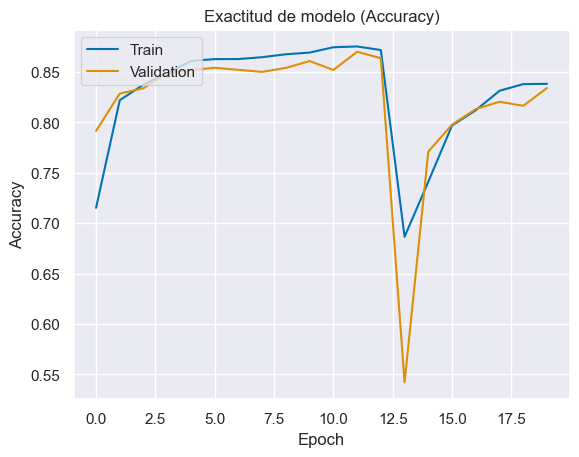

In [22]:
# gradicar evaluacion de modelo
# Evaluate the model
plt.plot(historial_unet.history['accuracy'])
plt.plot(historial_unet.history['val_accuracy'])
plt.title('Exactitud de modelo (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### Aplicar modelo a imagen completa

In [58]:
# crear el modelo con mejores pesos
best_model = keras.models.load_model("unet_ancon.h5")
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,380,043 (119.71 MB)

 Trainable params: 31,380,041 (119.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
# evaluar mejor modelo
loss, acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Metricas de mejor modelo, accuracy: {:5.2f}%'.format(100 * acc))


12/12 - 135s - 11s/step - accuracy: 0.8702 - loss: 0.3163
Metricas de mejor modelo, accuracy: 87.02%


In [25]:
# Aplicar modelo a la imagen completa
full_predicted_mask = np.zeros((filas_clasificada, columnas_clasificada, num_classes))

for i in range(0, filas_clasificada, patch_size):
    for j in range(0, columnas_clasificada, patch_size):
        patch = imagen_altura_unet_escalada[i : i + patch_size, j : j + patch_size, :]
        if patch.shape[:2] == (patch_size, patch_size):
            patch_pred = best_model.predict(patch[np.newaxis, ...])[0]
            full_predicted_mask[i : i + patch_size, j : j + patch_size, :] = patch_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Coonvertir de one-hot a clases

In [26]:
# Convertir de one-hot a clases
predicted_mask = np.argmax(full_predicted_mask, axis=-1)

# aplicar mascara
predicted_mask = np.where(mascara, np.nan, predicted_mask)

# validar dimensiones
predicted_mask.shape


(10104, 12080)

### Guardar ortofoto clasificada

In [ ]:
# definir la ruta de salida y nombre
nombre_salida = "Clasificacion_Ancon_Unet_4B"
carpeta_salida = r"/ortofoto/ancon/"
ruta_salida = os.path.join(carpeta_salida, f"{nombre_salida}.tif")

# crear el manejador de archivos de gdal
driver = gdal.GetDriverByName("GTiff")
driver.Register()

# crear en memoria la salida
dts_salida = driver.Create(ruta_salida, xsize=columnas_clasificada, ysize=filas_clasificada, bands= 1, eType=gdal.GDT_Byte)

# aplicar el geotransform
dts_salida.SetGeoTransform(geoTransform)

# aplicar la proyección
dts_salida.SetProjection(proj)

# leer dataset creado
banda_salida = dts_salida.GetRasterBand(1)

# crear banda para en disco salida
banda_salida.WriteArray(predicted_mask)

# agregar nodata
banda_salida.SetNoDataValue(np.nan)

# escribir en disco
banda_salida.FlushCache()

# asegurar que escriba en disco
banda_salida = None
dts_salida = None


### Aplicación de modelos a otra imagen

In [ ]:
# cargar ortofoto
ruta_ortofoto_sanAntonio = r"/ortofoto/SanAntonio_4B.tif"

# leer la ortofoto
img_sanAntonio = gdal.Open(ruta_ortofoto_sanAntonio)

# obtener dimensiones
n_bandas_sa = img_sanAntonio.RasterCount
filas_sa = img_sanAntonio.RasterYSize
columnas_sa = img_sanAntonio.RasterXSize
no_data_sa = img_sanAntonio.GetRasterBand(4).GetNoDataValue()
geoTransform_sa = img_sanAntonio.GetGeoTransform()
proj_sa = img_sanAntonio.GetProjection()

# imprimir dimensiones
print(f"Número de bandas: {n_bandas_sa}")
print(f"Número de columnas: {columnas_sa}")
print(f"Número de filas: {filas_sa}")
print(f"Valor no data: {no_data_sa}")

Número de bandas: 4
Número de columnas: 6090
Número de filas: 4038
Valor no data: -10000.0


In [60]:
# obtener las bandas
bandas_sa = [img_sanAntonio.GetRasterBand(i + 1).ReadAsArray() for i in range(n_bandas_sa)]

# crear una capa de mascada para no data
mascara_sa = img_sanAntonio.GetRasterBand(4).ReadAsArray()
mascara_sa = (mascara_sa == no_data_sa)

# aplicar la mascara
imagen_sa = np.array([np.where(mascara_sa, np.nan, banda) for banda in bandas_sa])

# liberar memoria
bandas_sa = None

imagen_sa.shape


(4, 4038, 6090)

In [61]:
# ciclo for para obtener estadisticas de cada banda
for banda in range(n_bandas_sa):
    print(f"Banda {banda+1}:")
    print(f"  Min: {np.nanmin(imagen_sa[banda])}")
    print(f"  Max: {np.nanmax(imagen_sa[banda])}")
    print(f"  Media: {np.nanmean(imagen_sa[banda])}")
    print(f"  Desviación estándar: {np.nanstd(imagen_sa[banda])}")


Banda 1:
  Min: 0.0
  Max: 255.0
  Media: 106.11589050292969
  Desviación estándar: 49.294036865234375
Banda 2:
  Min: 0.0
  Max: 255.0
  Media: 107.73846435546875
  Desviación estándar: 48.09830856323242
Banda 3:
  Min: 0.0
  Max: 255.0
  Media: 72.71376037597656
  Desviación estándar: 45.817474365234375
Banda 4:
  Min: 1722.6326904296875
  Max: 1909.9490966796875
  Media: 1796.93798828125
  Desviación estándar: 40.81398010253906


In [76]:
# convertir imagen en array de píxeles
flat_ortofoto_sa = imagen_sa.reshape(n_bandas_sa, -1).T

# escalar los datos con base en el escalador usado en preparacion de datos
flat_ortofoto_sa_escalado = escalador_altura.transform(flat_ortofoto_sa)

# validar dimensiones
flat_ortofoto_sa_escalado.shape


(24591420, 4)

### Aplicacion de Bosques Aleatorios a otra imagen

In [78]:
# prediccion random forest
sanAntonio_clasificada_rf = rf_busqueda.best_estimator_.predict(flat_ortofoto_sa_escalado)

# volver a dimensiones de ortofoto
sanAntonio_clasificada_rf = sanAntonio_clasificada_rf.reshape(filas_sa, columnas_sa)

# aplicar mascara
sanAntonio_clasificada_rf = np.where(mascara_sa, np.nan, sanAntonio_clasificada_rf)

In [ ]:
# definir la ruta de salida y nombre
nombre_salida = "Clasificacion_SanAntonio_RF_4B"
carpeta_salida = r"/raster/sanAntonio"
ruta_salida = os.path.join(carpeta_salida, f"{nombre_salida}.tif")

# crear el manejador de archivos de gdal
driver = gdal.GetDriverByName("GTiff")
driver.Register()

# crear en memoria la salida
dts_salida = driver.Create(ruta_salida, xsize=columnas_sa, ysize=filas_sa, bands= 1, eType=gdal.GDT_Byte)

# aplicar el geotransform
dts_salida.SetGeoTransform(geoTransform_sa)

# aplicar la proyección
dts_salida.SetProjection(proj_sa)

# leer dataset creado
banda_salida = dts_salida.GetRasterBand(1)

# crear banda para en disco salida
banda_salida.WriteArray(sanAntonio_clasificada_rf)

# agregar nodata
banda_salida.SetNoDataValue(np.nan)

# escribir en disco
banda_salida.FlushCache()

# asegurar que escriba en disco
banda_salida = None
dts_salida = None

### Aplicación de UNET a otra imagen

In [71]:
# reemplazar nan por -5
flat_ortofoto_sa_escalado = np.nan_to_num(flat_ortofoto_sa_escalado, nan=-10000)

# redimensionar
flat_ortofoto_sa_escalado = flat_ortofoto_sa_escalado.reshape(filas_sa, columnas_sa, n_bandas_sa)

# mostrar dimensiones
flat_ortofoto_sa_escalado.shape

(4038, 6090, 4)

In [72]:
patch_size = 256
num_classes = 9

# Aplicar modelo a la imagen completa
full_predicted_mask_sa = np.zeros((filas_sa, columnas_sa, num_classes))

for i in range(0, filas_sa, patch_size):
    for j in range(0, columnas_sa, patch_size):
        patch = flat_ortofoto_sa_escalado[i : i + patch_size, j : j + patch_size, :]
        if patch.shape[:2] == (patch_size, patch_size):
            patch_pred = best_model.predict(patch[np.newaxis, ...])[0]
            full_predicted_mask_sa[i : i + patch_size, j : j + patch_size, :] = patch_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [73]:
# Convertir de one-hot a clases
predicted_mask_sa = np.argmax(full_predicted_mask_sa, axis=-1)

# aplicar mascara
predicted_mask_sa = np.where(mascara_sa, np.nan, predicted_mask_sa)

# validar dimensiones
predicted_mask_sa.shape


(4038, 6090)

In [ ]:
# definir la ruta de salida y nombre
nombre_salida = "Clasificacion_SanAntonio_Unet_4B"
carpeta_salida = r"/raster/sanAntonio"
ruta_salida = os.path.join(carpeta_salida, f"{nombre_salida}.tif")

# crear el manejador de archivos de gdal
driver = gdal.GetDriverByName("GTiff")
driver.Register()

# crear en memoria la salida
dts_salida = driver.Create(ruta_salida, xsize=columnas_sa, ysize=filas_sa, bands= 1, eType=gdal.GDT_Byte)

# aplicar el geotransform
dts_salida.SetGeoTransform(geoTransform_sa)

# aplicar la proyección
dts_salida.SetProjection(proj_sa)

# leer dataset creado
banda_salida = dts_salida.GetRasterBand(1)

# crear banda para en disco salida
banda_salida.WriteArray(predicted_mask_sa)

# agregar nodata
banda_salida.SetNoDataValue(np.nan)

# escribir en disco
banda_salida.FlushCache()

# asegurar que escriba en disco
banda_salida = None
dts_salida = None